In [ ]:
import tensorflow as tf
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
import shutil
from keras.preprocessing.image import ImageDataGenerator
import random
import json
from PIL import Image
from keras.models import Sequential

In [ ]:
os.makedirs('C:/FinalProject/content/spectrograms3sec')
os.makedirs('C:/FinalProject/content/spectrograms3sec/train')
os.makedirs('C:/FinalProject/content/spectrograms3sec/test')

genres = 'blues classical country disco pop hiphop jazz metal reggae rock'
genres = genres.split()
for g in genres:
  path_audio = os.path.join('C:/FinalProject/content/audio3sec',f'{g}')
  os.makedirs(path_audio)
  path_train = os.path.join('C:/FinalProject/content/spectrograms3sec/train',f'{g}')
  path_test = os.path.join('C:/FinalProject/content/spectrograms3sec/test',f'{g}')
  os. makedirs(path_train)
  os. makedirs(path_test)

In [17]:
from pydub import AudioSegment
i = 0
for g in genres:
  j=0
  print(f"{g}")
  for filename in os.listdir(os.path.join('C:/FinalProject/data/genres',f"{g}")):

    song  =  os.path.join(f'C:/FinalProject/data/genres/{g}',f'{filename}')
    j = j+1
    for w in range(0,10):
      i = i+1
      #print(i)
      t1 = 3*(w)*1000
      t2 = 3*(w+1)*1000
      newAudio = AudioSegment.from_wav(song)
      new = newAudio[t1:t2]
      new.export(f'C:/FinalProject/content/audio3sec/{g}/{g+str(j)+str(w)}.wav', format="wav")

blues
classical
country
disco
pop
hiphop
metal
reggae
rock


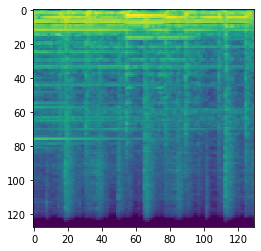

In [68]:
for g in genres:
  j = 0
  print(g)
  for filename in os.listdir(os.path.join('C:/FinalProject/content/audio3sec',f"{g}")):
    song  =  os.path.join(f'C:/FinalProject/content/audio3sec/{g}',f'{filename}')
    j = j+1
    
    y,sr = librosa.load(song,duration=3)
    #print(sr)
    mels = librosa.feature.melspectrogram(y=y,sr=sr)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
    plt.savefig(f'C:/FinalProject/content/spectrograms3sec/{g}/{g+str(j)}.png')

In [2]:
directory = "C:/FinalProject/content/spectrograms3sec/train/"
for g in genres:
  filenames = os.listdir(os.path.join(directory,f"{g}"))
  random.shuffle(filenames)
  test_files = filenames[0:100]

  for f in test_files:

    shutil.move(directory + f"{g}"+ "/" + f,"C:/FinalProject/spectrograms3sec/test/" + f"{g}")



NameError: name 'genres' is not defined

In [32]:
train_dir = "C:/FinalProject/content/spectrograms3sec/train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=128)

validation_dir = "C:/FinalProject/content/spectrograms3sec/test/"
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=128)


Found 9000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [1]:
def GenreModel(input_shape = (288,432,4),classes=10):
  np.random.seed(10)
  X_input = Input(input_shape)

  X = Conv2D(8,kernel_size=(3,3),strides=(1,1),kernel_initializer = glorot_uniform(seed=10))(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(16,kernel_size=(3,3),strides = (1,1),kernel_initializer=glorot_uniform(seed=10))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(32,kernel_size=(3,3),strides = (1,1),kernel_initializer = glorot_uniform(seed=10))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64,kernel_size=(3,3),strides=(1,1),kernel_initializer=glorot_uniform(seed=10))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
   
  X = Conv2D(128,kernel_size=(3,3),strides=(1,1),kernel_initializer=glorot_uniform(seed=10))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  
  X = Flatten()(X)

  X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=10))(X)

  model = Model(inputs=X_input,outputs=X,name='GenreModel')

  return model

In [3]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [40]:
model = GenreModel(input_shape=(288,432,4),classes=10)
opt = Adam(learning_rate=0.00005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',get_f1])

In [194]:
trn= model.fit(train_generator,epochs=50,validation_data=vali_generator)

Epoch 1/50
71/71 [==============================] - ETA: 20:17 - loss: 3.0445 - accuracy: 0.0938 - get_f1: 0.02 - ETA: 11:17 - loss: 2.9944 - accuracy: 0.0859 - get_f1: 0.01 - ETA: 11:10 - loss: 2.9004 - accuracy: 0.0859 - get_f1: 0.00 - ETA: 11:08 - loss: 2.8047 - accuracy: 0.0918 - get_f1: 0.00 - ETA: 11:15 - loss: 2.7252 - accuracy: 0.0938 - get_f1: 0.00 - ETA: 11:20 - loss: 2.6681 - accuracy: 0.0924 - get_f1: 0.00 - ETA: 11:17 - loss: 2.6229 - accuracy: 0.0915 - get_f1: 0.00 - ETA: 11:08 - loss: 2.5854 - accuracy: 0.0947 - get_f1: 0.00 - ETA: 11:00 - loss: 2.5612 - accuracy: 0.0998 - get_f1: 0.00 - ETA: 10:50 - loss: 2.5399 - accuracy: 0.1031 - get_f1: 0.00 - ETA: 10:41 - loss: 2.5328 - accuracy: 0.1030 - get_f1: 0.00 - ETA: 10:29 - loss: 2.5224 - accuracy: 0.1074 - get_f1: 0.00 - ETA: 10:18 - loss: 2.5215 - accuracy: 0.1076 - get_f1: 0.00 - ETA: 10:07 - loss: 2.5099 - accuracy: 0.1099 - get_f1: 0.00 - ETA: 9:57 - loss: 2.5005 - accuracy: 0.1089 - get_f1: 0.0019 - ETA: 9:46 - loss:

In [7]:
def plot_performance(hist):
    
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [8]:
plot_performance(model)

TypeError: 'NoneType' object is not subscriptable

In [4]:
sample ='C:/FinalProject/Slipknot - Psychosocial.wav'

In [5]:
from pydub import AudioSegment  
t1 = 3*(9)*1000
t2 = 3*(10)*1000
wav = AudioSegment.from_wav(sample)
wav = wav[t1:t2] 
wav.export("extracted.wav",format='wav')

<_io.BufferedRandom name='extracted.wav'>

In [6]:
def create_melspectrogram(wav_file):  
  y,sr = librosa.load(wav_file)  
  mels = librosa.feature.melspectrogram(y=y,sr=sr)    
  fig = plt.Figure()  
  canvas = FigureCanvas(fig) 
  p = plt.imshow(librosa.power_to_db(mels,ref=np.max))   
  plt.savefig('melspectrogram.png')

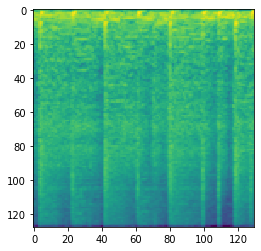

In [7]:
create_melspectrogram("extracted.wav")

In [8]:
image_data = tf.keras.utils.load_img('melspectrogram.png',color_mode='rgba',target_size=(288,432))

In [9]:
def predict(image_data,model):   
  image = tf.keras.utils.img_to_array(image_data)   
  image = np.reshape(image,(1,288,432,4))   
  prediction =  model.predict(image/255)  
  prediction = prediction.reshape((10,))     
  class_label = np.argmax(prediction)     
  return class_label,prediction
class_labels = ['blues', 'classical', 'country', 'disco', 'hiphop','jazz', 'metal', 'pop', 'reggae', 'rock']

In [10]:
class_label,prediction = predict(image_data,model)

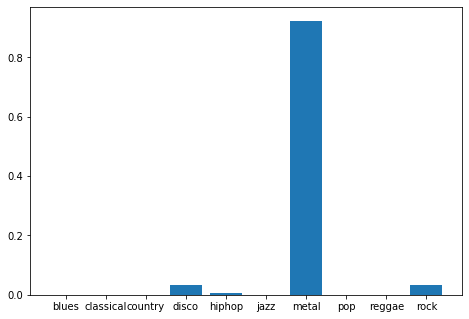

In [11]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(class_labels,prediction)
plt.show()

In [2]:
import keras.models

In [2]:
model=load_model('C:\FinalProject\model.h5',compile = False)

In [3]:
model.summary()

Model: "GenreModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 288, 432, 4)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 286, 430, 8)       296       
                                                                 
 batch_normalization_4 (Batc  (None, 286, 430, 8)      32        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 286, 430, 8)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 143, 215, 8)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 141, 213, 16)      1

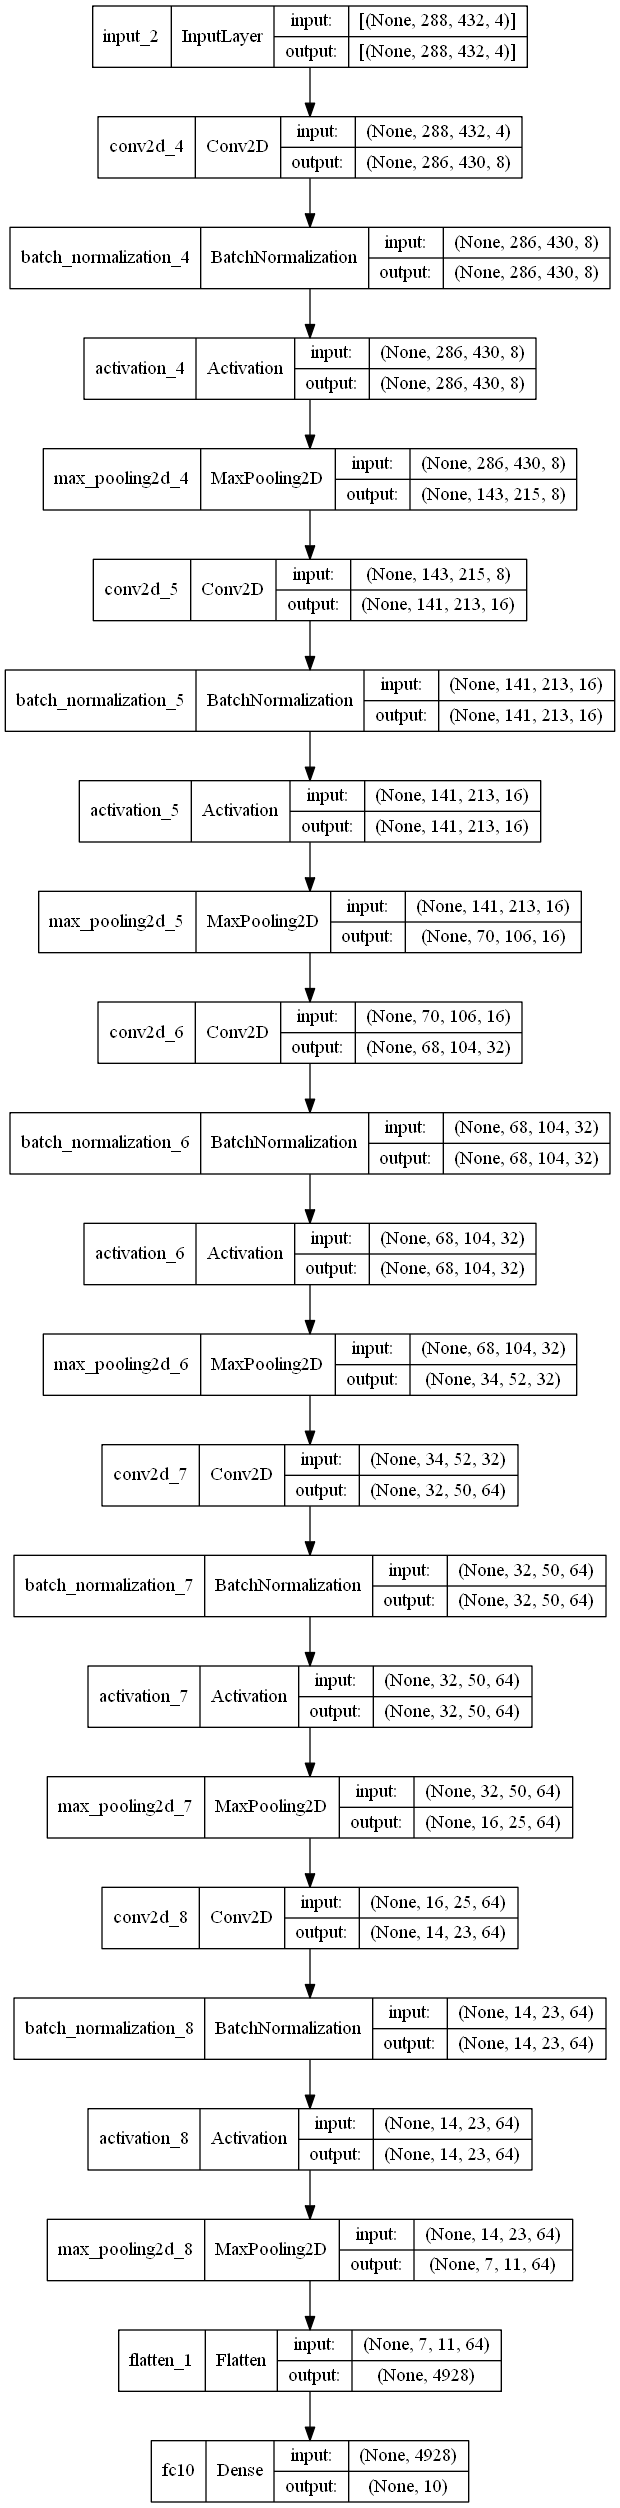

In [7]:
import keras
import pydot
import pydotplus
from pydotplus import graphviz
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot   
tf.keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True, show_layer_names=True)